In [ ]:
from google.colab import drive
drive.mount('/content/drive')


drive_base_path = '/content/drive/My Drive'
tar_file = f'{drive_base_path}/millionsongsubset.tar.gz'
msongsdb_path = f'{drive_base_path}/MSongsDB'
python_src_path = f'{msongsdb_path}/PythonSrc'
extract_dir = '/content/millionsongsubset_extracted'

import sys
import os
import tarfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from collections import Counter

sys.path.append(python_src_path)

# Python search paths (used for google drive specifically)
print("\nPython search paths:")
for path in sys.path:
    print(path)

#importation of hdf5_getters
try:
    from hdf5_getters import *
    print("\nImport of hdf5_getters success")
except ModuleNotFoundError as e:
    print(f"\nhdf5_getters import failed: {e}")


# zip file extraction
if not os.path.exists(extract_dir):
    print("\nExtracting dataset...")
    with tarfile.open(tar_file, 'r:gz') as tar:
        tar.extractall(path=extract_dir)
    print(f"Extracted files to {extract_dir}")
else:
    print("\nDataset already extracted. Skipping extraction.")

h5_files_path = os.path.join(extract_dir, "MillionSongSubset")

# total number of .h5 files
h5_count = 0
for root, dirs, files in os.walk(h5_files_path):
    for file in files:
        if file.endswith('.h5'):
            h5_count += 1
print(f"Total number of .h5 files: {h5_count}")

# genre mappings
genre_mapping = {
    # rock
    'alternative': 'rock',
    'alternative rock': 'rock',
    'classic rock': 'rock',
    'hard rock': 'rock',
    'punk': 'rock',
    'grunge': 'rock',
    'garage rock': 'rock',

    # blues
    'blues': 'blues',
    'blues-rock': 'blues',
    'country blues': 'blues',
    'delta blues': 'blues',

    # Hip-Hop
    'hip hop': 'hip hop',
    'gangster rap': 'hip hop',
    'rap': 'hip hop',
    'rap rock': 'hip hop',
    'rapcore': 'hip hop',

    # electronic
    'electro': 'electronic',
    'techno': 'electronic',
    'house': 'electronic',
    'dubstep': 'electronic',
    'trance': 'electronic',
    'chill-out': 'electronic',

    # country
    'country': 'country',
    'country blues': 'country',
    'country rock': 'country',

    # jazz
    'jazz': 'jazz',
    'smooth jazz': 'jazz',
    'jazz fusion': 'jazz',
    'swing': 'jazz',

    # classical
    'classical': 'classical',
    'opera': 'classical',
    'orchestral': 'classical',
    'symphony': 'classical',

    # folk
    'folk': 'folk',
    'folk rock': 'folk',
    'folk-pop': 'folk',

    # reggae
    'reggae': 'reggae',
    'roots reggae': 'reggae',
    'dub': 'reggae',

    # latin
    'salsa': 'latin',
    'bossa nova': 'latin',
    'latin jazz': 'latin',

    # pop
    'pop': 'pop',
    'pop rock': 'pop',
    'dance pop': 'pop',

    # metal
    'metal': 'metal',
    'heavy metal': 'metal',
    'black metal': 'metal',
    'death metal': 'metal',
}

# parse features and apply genre mapping
max_files = 10000 # Usually takes about 5 minutes to parse, decrease to speed up testing
song_count = 0
features = []
labels = []

for root, dirs, files in os.walk(h5_files_path):
    for file in files:
        if file.endswith('.h5'):
            h5_file_path = os.path.join(root, file)
            with open_h5_file_read(h5_file_path) as h5_file: #feature extraction
                tempo = get_tempo(h5_file)
                key = get_key(h5_file)
                loudness = get_loudness(h5_file)
                duration = get_duration(h5_file)
                artist_terms = get_artist_terms(h5_file)
                genre = artist_terms[0].decode() if artist_terms.size > 0 else None

                #map genre and skip if unmapped
                mapped_genre = genre_mapping.get(genre, None)
                if mapped_genre:
                    features.append([tempo, key, loudness, duration])
                    labels.append(mapped_genre)

                song_count += 1
                if song_count % 200 == 0: #print parsing marker every 200 songs
                    print(f"Processed {song_count} songs so far")
                if song_count >= max_files:
                    break

            h5_file.close()
    if song_count >= max_files:
        break

print(f"Total number of songs processed: {song_count}")

# pd DataFrame convt
data = pd.DataFrame(features, columns=['Tempo', 'Key', 'Loudness', 'Duration'])
data['Genre'] = labels

# Filter dataset to only include valid genres
valid_genres = list(genre_mapping.values())
data = data[data['Genre'].isin(valid_genres)]

# updated genre distribution
genre_distribution = Counter(data['Genre'])
print(f"Genre distribution after filtering: {genre_distribution}")

# dataset splitting into test and train data
X = data[['Tempo', 'Key', 'Loudness', 'Duration']]
y = data['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize music features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN training
k = 5 # tested with neighboring values
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Model Evalution
y_pred = knn.predict(X_test) # prediction evalution
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

actual_genres = sorted(set(y_test))  # unique genres in the test set
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=actual_genres)) #report of classifiction accuracy



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Python search paths:
/content
/env/python
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload

/usr/local/lib/python3.10/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.10/dist-packages/IPython/extensions
/usr/local/lib/python3.10/dist-packages/setuptools/_vendor
/root/.ipython
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MSongsDB/PythonSrc
/content/drive/My Drive/MS

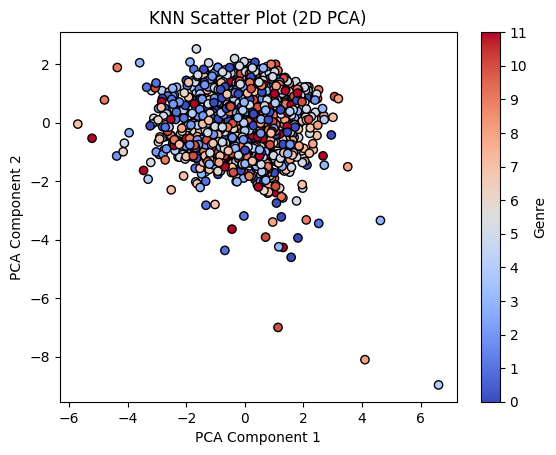

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

le = LabelEncoder() # convert y_train to numeric value
y_train_numeric = le.fit_transform(y_train)

knn_2d = KNeighborsClassifier(n_neighbors=k) # KNN train
knn_2d.fit(X_train_2d, y_train_numeric)

# scatter plot
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_numeric, cmap=plt.cm.coolwarm, edgecolor="k")
plt.title("KNN Scatter Plot (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Genre")
plt.show()
